# Unlearning Experiments ([steps](https://www.overleaf.com/project/623aa8d6b133433e9006bc8a))

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install pyvacy
from pyvacy import optim, analysis

In [ ]:
# Get MNIST data
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [ ]:
# Set batch size
batch_size = 50

# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define 3-layer fully connected neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Using cuda device


In [ ]:
# Trains for one epoch.
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Discard element if it was marked as the removed one (y == -1)
        if -1 in y:
            index_removed = int((y == -1).nonzero(as_tuple=True)[0][0])
            y = torch.cat((y[:index_removed], y[index_removed + 1:]))
            X = torch.cat((X[:index_removed, :], X[index_removed + 1:, :]))

        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
# Prints the accuracy and average loss for the test set.
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [ ]:
# Define loss function and hyperparameters.
loss_fn = nn.CrossEntropyLoss()
lr = 1e-2
num_epochs = 30
delta = 0.1

In [ ]:
# Sample U (one element) from specified label and get dataset without U.
def get_modified_training_dataloader(label, batch_size):
    # Create copy of dataset to modify
    modified_dataset = datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )

    # Find index of first element from class i (the single element in set of 
    # delete requests U). It does not matter that it is the first because we
    # are randomly shuffling
    indicies_from_class = modified_dataset.targets == label
    index_of_u = int((indicies_from_class == True).nonzero()[0][0]) # Doesn't matter which one we pick because of shuffling

    # Mark the removed element with "-1" class to discard while training.
    modified_dataset.targets[index_of_u] = -1
    
    return DataLoader(modified_dataset, batch_size=batch_size, shuffle=True)

a = get_modified_training_dataloader(0, 100)


# Trains a neural network for a given number of epochs.
def train_model(model, train_dataloader, optimizer, test_dataloader = test_dataloader, loss_fn = loss_fn, num_epochs = 100):
    for t in range(num_epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test(test_dataloader, model, loss_fn)
    print("Done!")

In [ ]:
# Initialize list of models
models = []
num_classes_to_delete_point_from = 10

# Compute w and noisy ws for each random seed. For loop in the form i, i+1 to 
# avoid problems with runtime disconnecting (each iteration takes approx 2 hrs).
for seed in range(0, 1):
    seed_models = []

    # Set seed for training on regular dataset
    random.seed(seed)
    torch.manual_seed(seed)

    # Get new dataloader appropriate for seed (shuffling has an effect)
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

    # Train for w(S)
    model_regular = NeuralNetwork().to(device)
    optimizer = torch.optim.SGD(model_regular.parameters(), lr=lr)
    train_model(model_regular, train_dataloader, optimizer, num_epochs = num_epochs)

    seed_models.append(model_regular)

    # Train for each of the w(S\U) 
    models_modified = []
    for label in range(num_classes_to_delete_point_from):
        print("Removing an element from class: " + str(label))

        # Set the same seed to start each training iteration
        random.seed(seed)
        torch.manual_seed(seed)

        # Remove an element from the training dataset
        modified_train_dataloader = get_modified_training_dataloader(label, batch_size)

        # Create and train model for the modified dataset
        model_modified = NeuralNetwork().to(device)
        optimizer = torch.optim.SGD(model_modified.parameters(), lr=lr)
        train_model(model_modified, modified_train_dataloader, optimizer, num_epochs = num_epochs)

        models_modified.append(model_modified)

    seed_models.append(models_modified)
    models.append(seed_models)

In [ ]:
# Applies a function to each element of a nested list
def apply(item, fun):
    if isinstance(item, list):
        return [apply(x, fun) for x in item]
    else:
        return fun(item)

# Return a 1D representation of all the weights in the model.
def get_weights(model):
    weights = []
    for _, param in model.named_parameters():
        weights.append(param.data.flatten())
    return torch.concat(weights)

model_weights = apply(models.copy(), get_weights)

# Compute the d_1(U) values
def get_d_values(model_weights):
  d_values = []
  for seed in range(1):
      values_for_seed = []
      for label in range(len(model_weights[seed][1])):
          difference = model_weights[seed][0] - model_weights[seed][1][label]
          print("L2 norm of w from regular model: " + str(float(torch.norm(model_weights[seed][0], 2))))
          print("L2 norm of w from model with element removed from class " + str(label) + ": " + str(float(torch.norm(model_weights[seed][1][label], 2))))
          print("L2 norm of their difference: " + str(float(torch.norm(difference, 2))) + "\n")
          values_for_seed.append(torch.norm(difference, 2))
      d_values.append(values_for_seed)
  return d_values

d_values = get_d_values(model_weights)

saved_model_params = apply(models.copy(), lambda x : x.state_dict())

# Compute test error for w(S) models and w(S\U) models for fixed epsilon/delta.
def compute_all_losses(models, saved_model_params, epsilon, delta, d_values, loss_fn = loss_fn, test_dataloader = test_dataloader):
    # Compute standard deviation of Gaussain noise to add to each model
    c = np.sqrt(2 * np.log(1.25/delta))
    sigma_divided_by_d = c / epsilon

    with torch.no_grad():
        accuracies = []
        for seed in range(1):
            print("Seed: " + str(seed))
            print("Regular test error (without removing an element or adding noise)")
            test(test_dataloader, models[seed][0], loss_fn)

            for label in range(len(saved_model_params[seed][1])):
                np.random.seed(0)
                print("Seed: " + str(seed))
                print("Delete requests U is an element from class: " + str(label))
                model = NeuralNetwork()
                model.to(device)
                model.load_state_dict(saved_model_params[seed][1][label])
                # Add noise to w(S \ U)
                for param in model.parameters():  
                    sigma = sigma_divided_by_d * d_values[seed][label]
                    a = np.array([])
                    a = np.random.normal(0, 1)
                    param.add_(torch.tensor(np.random.normal(0, sigma.cpu())))
                accuracies.append(test(test_dataloader, model, loss_fn))
    return accuracies
epsilon, delta = 2, 0.1
compute_all_losses(models, saved_model_params, epsilon, delta, d_values)


In [ ]:
# Save models (code has been changed at each iteration)
from google.colab import files

torch.save(models[2].state_dict(), "model_reg_seed_0.pt")
files.download("model_reg_seed_0.pt")
for i in range(num_classes_to_delete_point_from):
  filename = "model_removed_" + str(i) + "_seed_0.pt"
  torch.save(models[0][i].state_dict(), filename)
  files.download(filename)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute test error after adding noise to final model params
epsilon_vals = np.linspace(1, 40, 40)
#noise_accuracies = []

#for epsilon in epsilon_vals:
    #noise_accuracies.append(np.mean(compute_all_losses(models, saved_model_params, epsilon, delta, d_values)))

graph = sns.lineplot(x = epsilon_vals, y = noise_accuracies)
graph.axhline(test(test_dataloader, models[0][0], loss_fn))
plt.title("Epsilon vs Average Accuracy (fixed delta = 0.1)")
plt.show()


In [ ]:
# Find noise parameter for epsilon provided
def find_noise_parameter(eps, delta, training_data, batch_size, num_epochs, max_iters):
  # F returns epsilon
  def f(delta, training_data, batch_size, num_epochs, len_training_data, noise_multiplier):
    return analysis.moments_accountant(
        N=len(training_data),
        batch_size=batch_size,
        noise_multiplier=noise_multiplier,
        epochs=num_epochs,
        delta=delta,
      )
    
  len_training_data = len(training_data)

  return _binary_search(f, 0.1, 100, eps, max_iters, delta, training_data, batch_size, num_epochs, len_training_data)

def _binary_search(f, left, right, goal, iterations, delta, training_data, batch_size, num_epochs, len_training_data):
    """Performs a search over a closed domain [left, right] for the value which get f close to goal(epsilon)."""
    for i in range(iterations):
        middle = (left + right) / 2
        if f(delta, training_data, batch_size, num_epochs, len_training_data, middle) > goal:
          left = middle
        else:
          right = middle
    return (left + right) / 2

# Check noise param is found correctly. 
print(analysis.moments_accountant(
    N=len(training_data),
    batch_size=batch_size,
    noise_multiplier=0.3,
    epochs=num_epochs,
    delta=0.1,
))
find_noise_parameter(41.54867122425879, 0.1, training_data, batch_size, num_epochs, 40)

41.54867122425879


0.3000000000425188

In [ ]:
# Compute DPSGD accuracies
dpsgd_accuracies = []
epsilon_vals = np.linspace(0.5, 40, 5)
clipping_norm = [1.5, 2]
clip = 1
for seed in range(0, 1):
  for eps in epsilon_vals:
    #for clip in clipping_norm:
      random.seed(seed)
      torch.manual_seed(seed)  
      
      train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
      
      model = NeuralNetwork().to(device)

      noise_multiplier = find_noise_parameter(eps, delta, training_data, batch_size, num_epochs, 40)

      optimizer = optim.DPSGD(
        l2_norm_clip=clip,
        noise_multiplier=noise_multiplier,
        batch_size=batch_size,
        lr=lr,
        params=model.parameters()
      )

      train_model(model, train_dataloader, optimizer, num_epochs = num_epochs)
      dpsgd_accuracies.append(test(test_dataloader, model, loss_fn))

In [ ]:
# Visualize change in noise params for different epsilon
epsilon_vals = np.linspace(1, 40, 40)
for eps in epsilon_vals:
  print(find_noise_parameter(eps, 0.1, training_data, batch_size, num_epochs, 15))

0.7051681518554688
0.5710250854492187
0.5161483764648438
0.4856613159179688
0.46127166748046877
0.44297943115234373
0.43078460693359377
0.4185897827148438
0.40639495849609375
0.40029754638671877
0.39115142822265625
0.38505401611328127
0.3789566040039063
0.3728591918945312
0.36676177978515623
0.3637130737304688
0.3576156616210937
0.35456695556640627
0.35151824951171873
0.3484695434570312
0.34542083740234375
0.3423721313476562
0.33932342529296877
0.33627471923828123
0.3332260131835937
0.33017730712890625
0.3271286010742187
0.32407989501953116
0.32407989501953116
0.32103118896484373
0.3179824829101562
0.31493377685546875
0.31493377685546875
0.3118850708007812
0.3118850708007812
0.30883636474609377
0.30578765869140623
0.30578765869140623
0.3027389526367188
0.3027389526367188


Test Error: 
 Accuracy: 97.0%, Avg loss: 0.099635 



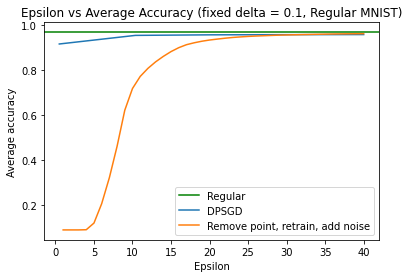

In [ ]:
# Compare all three methods (Regular, (Remove point, retrain, add noise), DPSGD)
graph = sns.lineplot()
graph.axhline(test(test_dataloader, models[0][0], loss_fn), color='green')
sns.lineplot(x = epsilon_vals, y = dpsgd_accuracies)
sns.lineplot(x = np.linspace(1, 40, 40), y = noise_accuracies)
plt.legend(labels=['Regular', 'DPSGD', 'Remove point, retrain, add noise'])
plt.title("Epsilon vs Average Accuracy (fixed delta = 0.1, Regular MNIST)")
plt.xlabel("Epsilon")
plt.ylabel("Average accuracy")
plt.show()